In [1]:
import warnings
warnings.filterwarnings('ignore')

import mxnet as mx
import numpy as np
import gluoncv as gcv
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from mxnet import nd, image
from mxnet.gluon.data.vision import transforms
from gluoncv.model_zoo import get_model
from gluoncv.utils import viz, download

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

In [2]:
plt.rcParams['figure.figsize'] = (15, 9)

# Image Classification

With this one-line code, we can load a pre-trained **ResNet50_v1** model for classification.

In [3]:
ctx = mx.cpu(0)
net = gcv.model_zoo.resnet50_v1b(pretrained=True, ctx=ctx)

With another one-line code we can have our prediction.

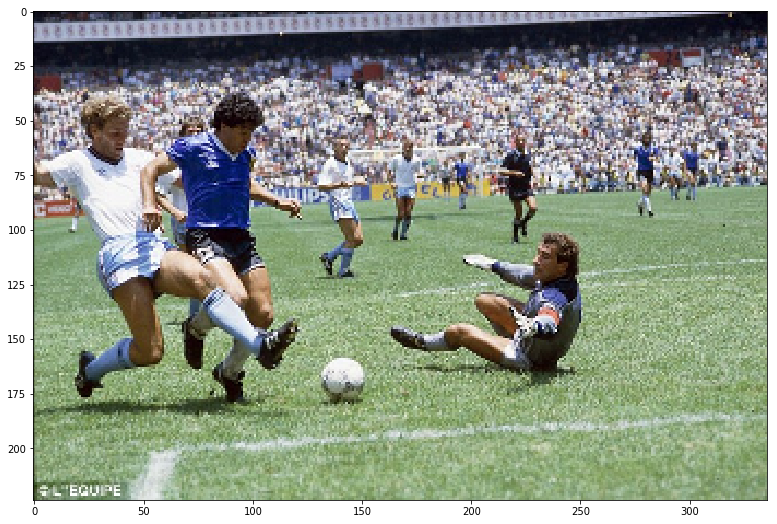

In [4]:
x, img = gcv.data.transforms.presets.ssd.load_test('support/goal.jpg', short=224)
viz.plot_image(img)

In [5]:
%%time
pred = net(x.as_in_context(ctx))

CPU times: user 46.5 ms, sys: 11 ms, total: 57.5 ms
Wall time: 31.9 ms


Let's review the top 5 prediction results.

In [6]:
classes_fname = download('https://raw.githubusercontent.com/hetong007/gluon-cv/master/scripts/classification/imagenet/imagenet_labels.txt',
                         'imagenet_labels.txt')
with open('imagenet_labels.txt', 'r') as f:
    class_names = [l.strip('\n') for l in f.readlines()]

In [7]:
ind = pred.topk(k=5).astype('int')[0]

for i in range(5):
    
    print('[%s], with probability %.1f%%'%
         (class_names[ind[i].asscalar()], nd.softmax(pred)[0][ind[i]].asscalar()*100))

[soccer_ball], with probability 47.5%
[rugby_ball], with probability 22.9%
[football_helmet], with probability 6.2%
[ballplayer], with probability 1.7%
[baseball], with probability 1.1%


# Object Detection

Image classifications are trained to recognize the main object in the scene. What if we have multiple subjects?

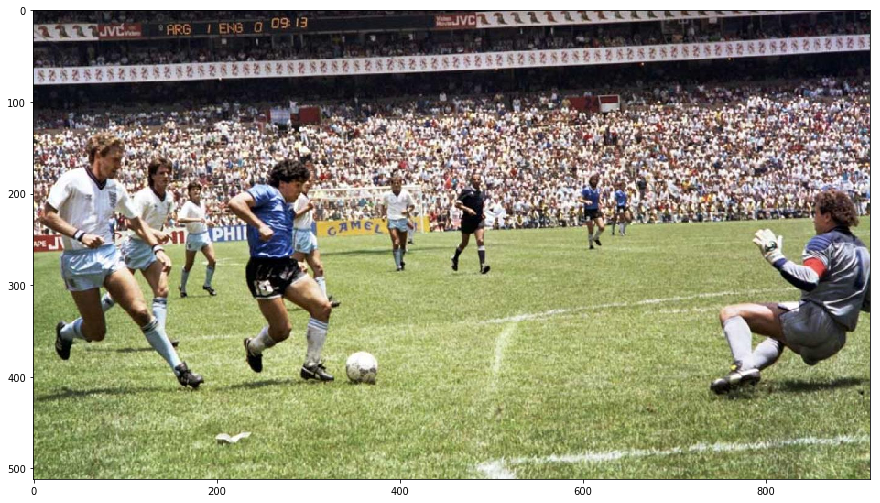

In [8]:
x, img = gcv.data.transforms.presets.ssd.load_test('support/diego.jpg', short=512)
viz.plot_image(img)
plt.show()

- Single Shot MultiBox Detector
- For each location, we got k bounding boxes. These k bounding boxes have different sizes and aspect ratios.
- For each of the bounding box, we will compute c class scores and 4 offsets relative to the original default bounding box shape

We can instead predict with an object detection model **SSD**.
![](support/ssd.png)
![](https://i.stack.imgur.com/Z3cIS.png)

In [9]:
ctx = mx.cpu(1)
net = get_model('ssd_512_resnet50_v1_coco', pretrained=True, ctx=ctx)

Now we predict. Notice we have three output variables.

In [10]:
%%time
class_IDs, scores, bounding_boxes = net(x.as_in_context(ctx))

CPU times: user 87.6 ms, sys: 72.5 ms, total: 160 ms
Wall time: 71.2 ms


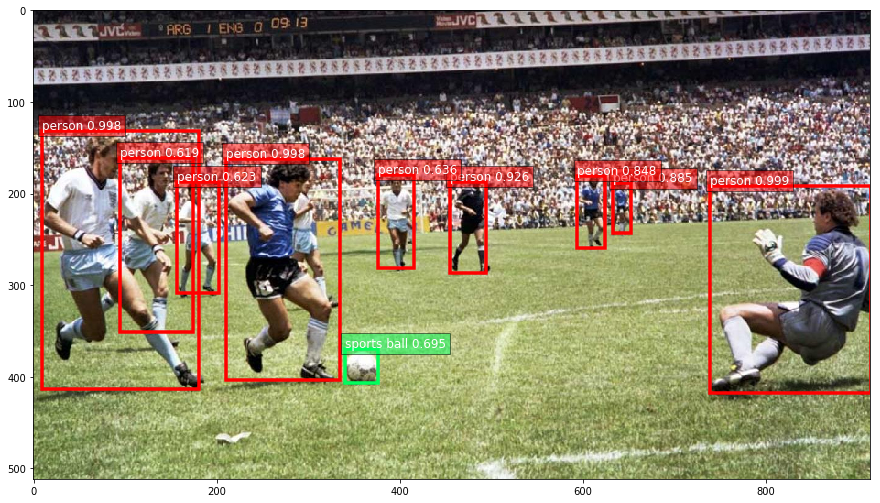

In [11]:
viz.plot_bbox(img, bounding_boxes[0], scores[0], class_IDs[0], class_names=net.classes)
plt.show()

How about we count how many people are here today?

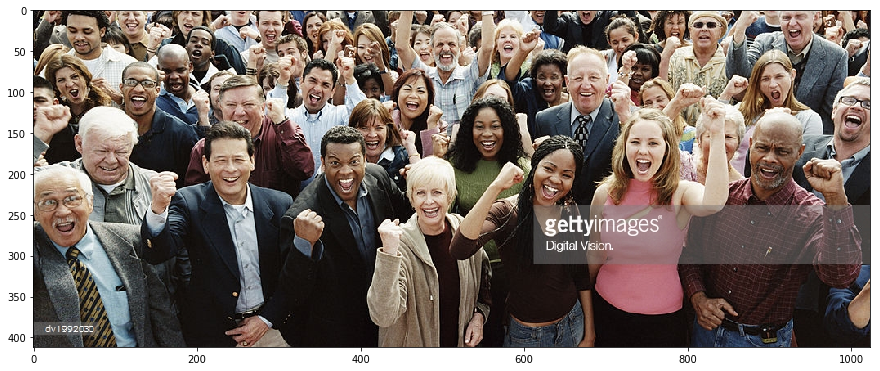

In [12]:
x, img = gcv.data.transforms.presets.ssd.load_test('support/crowd.jpg', short=512)
viz.plot_image(img)
plt.show()

There are 51 people in this photo.


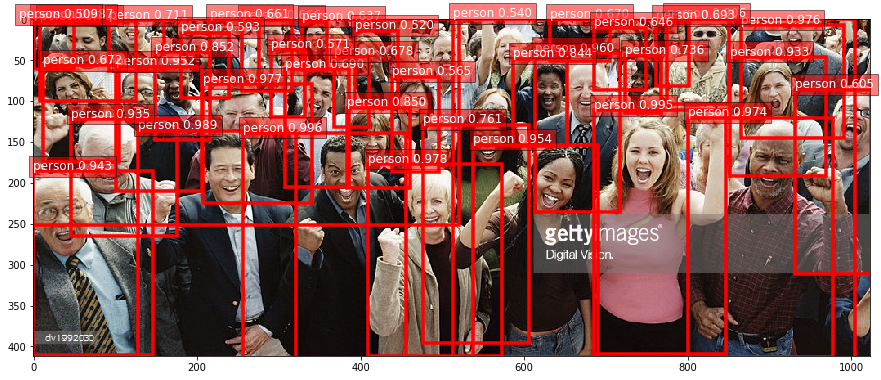

In [13]:
class_IDs, scores, bounding_boxes = net(x.as_in_context(mx.cpu(1)))
person_ind = [i for i, cls in enumerate(net.classes) if cls == 'person']
ind = np.nonzero(class_IDs[0].asnumpy() == person_ind)[0]

new_class_IDs = class_IDs[0][ind]
new_scores = scores[0][ind]
new_bounding_boxes = bounding_boxes[0][ind]

viz.plot_bbox(img, new_bounding_boxes, new_scores, new_class_IDs, class_names=net.classes)

print('There are %d people in this photo.'%(len(ind)))

Another scenario, following the heating topic: automated driving.

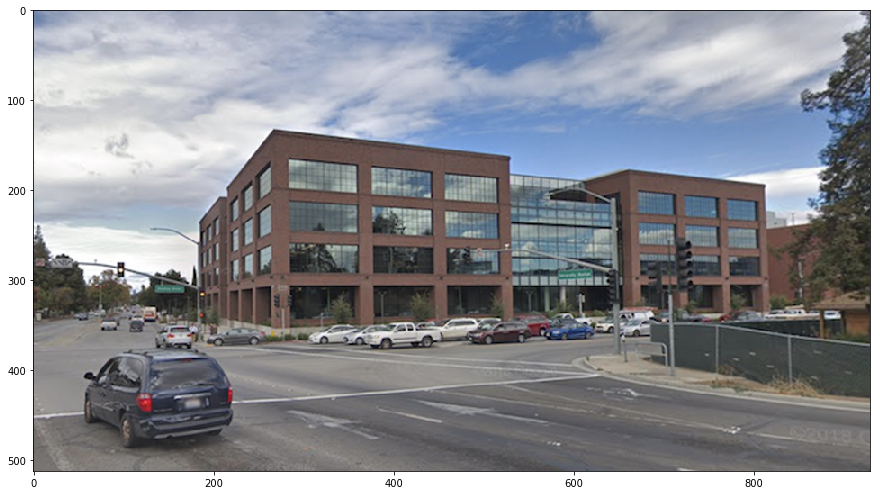

In [14]:
x, img = gcv.data.transforms.presets.ssd.load_test('support/streetview_amazon.png', short=512)
viz.plot_image(img)
plt.show()

In [15]:
%%time
class_IDs, scores, bounding_boxs = net(x.as_in_context(ctx))

CPU times: user 44.1 ms, sys: 19 ms, total: 63.1 ms
Wall time: 35.5 ms


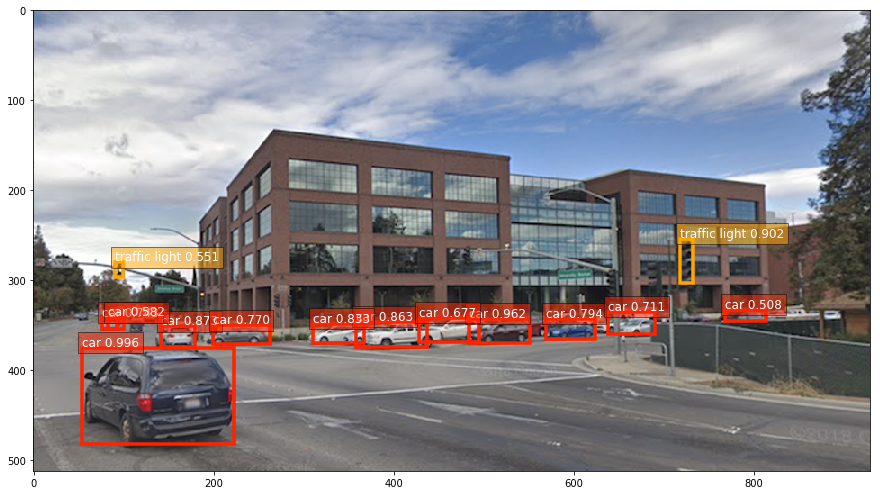

In [16]:
viz.plot_bbox(img, bounding_boxs[0], scores[0], class_IDs[0], class_names=net.classes)
plt.show()

# Semantic Segmentation

- Semantic segmentation takes the concept further, by predicting the class for every pixel.
- Fully Convolutional Network for Semantic Segmentation
- Resnet50 == backbone network

To obtain a segmentation map (output), segmentation networks usually have 2 parts :

    Downsampling path : capture semantic/contextual information
    Upsampling path : recover spatial information

The downsampling path is used to extract and interpret the context (what), while the upsampling path is used to enable precise localization (where). Furthermore, to fully recover the fine-grained spatial information lost in the pooling or downsampling layers, we often use skip connections.

Typcalliy in image classification, you have convolutions followed by dense layers to learn local and global featurs in an image. dense layers loose spatial information and are not suitable for image segmentation. So they use instead fully convoltuion networks where dense layers are replaced by convoltuional layers. 

they often use skip-connection to transfer information from higher to lower layers without going through the intermediate layers

In [17]:
ctx = mx.cpu(2)
net = get_model('fcn_resnet50_ade', pretrained=True, ctx=ctx)

In [28]:
%%time
output = net.demo(x.as_in_context(ctx))
pred = output.argmax(1).asnumpy().squeeze()

CPU times: user 13.1 s, sys: 1.12 s, total: 14.2 s
Wall time: 7.85 s


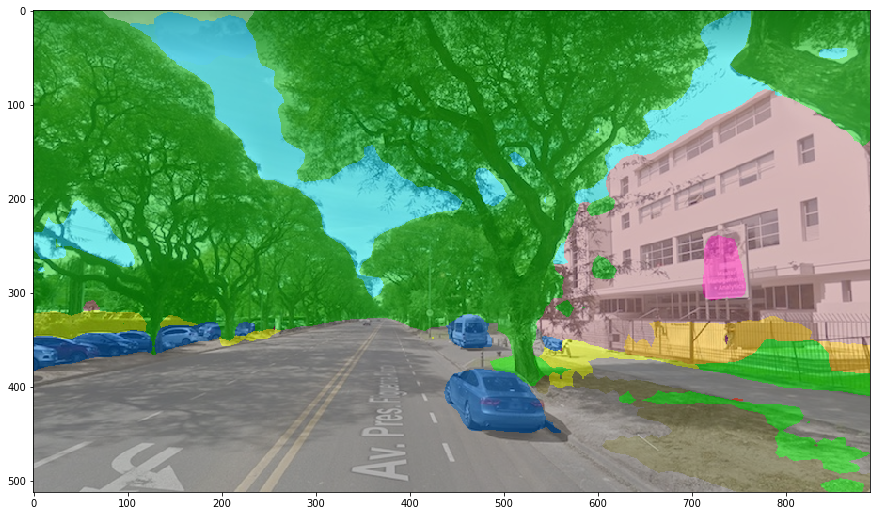

In [29]:
mask = viz.get_color_pallete(pred, 'ade20k')
mask = np.array(mask.convert('RGB'), dtype=np.int)

combined = (mask+img)/2

plt.imshow(combined.astype(np.uint8))
plt.show()

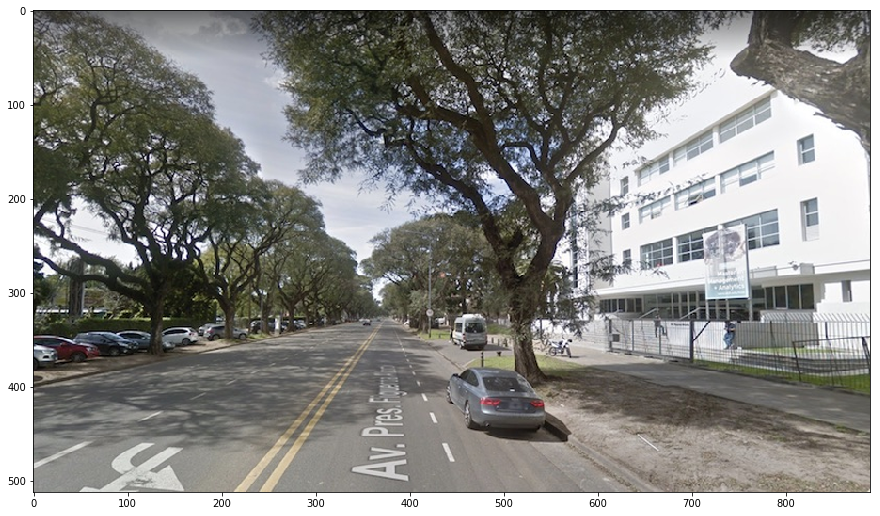

In [20]:
x, img = gcv.data.transforms.presets.ssd.load_test('support/road2.jpg', short=512)
viz.plot_image(img)
plt.show()

In [21]:
%%time
output = net.demo(x.as_in_context(ctx))
pred = output.argmax(1).asnumpy().squeeze()

CPU times: user 12.7 s, sys: 1.34 s, total: 14.1 s
Wall time: 7.29 s


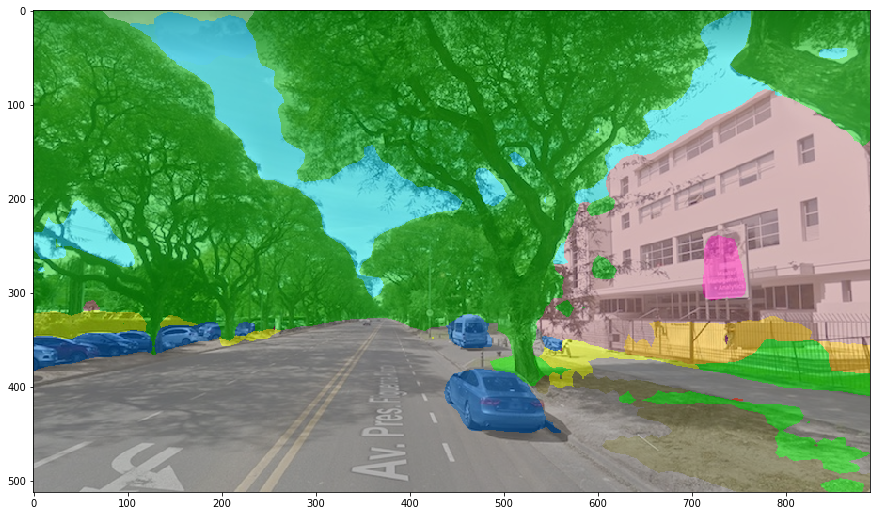

In [22]:
mask = viz.get_color_pallete(pred, 'ade20k')
mask = np.array(mask.convert('RGB'), dtype=np.int)

combined = (mask+img)/2
plt.imshow(combined.astype(np.uint8))
plt.show()